<a href="https://colab.research.google.com/github/uliiiiiiii/intro-to-ml/blob/main/Momentum_Lab_End2End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Learning from Image Data

## Part 0: Getting Started

Like in Lab 3, we will be using [PyTorch](https://pytorch.org/) to create and use neural network models without having to do any of the math ourselves. PyTorch runs all the math in the background so that we can focus on the inputs and outputs to the neural network model.


In [ ]:
#@title Installation

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

Building off the last lab, you will build a computer program that can look at black-and-white images of hand-written digits and automatically recognize what number (0-9) is there. Like before, we will use the **MNIST** dataset of images of hand-written digits, and split into *training* data and *test* data.

To refresh, remember that the model learns to model the *training* data. The *trained* model is then applied to new data, called *test* data, which is used to test how well the model does.

First we will download the MNIST data!

In [ ]:
#@title Download MNIST data

training_data = datasets.MNIST("./data", train=True, download=True,
      transform=transforms.ToTensor(),
)
test_data = datasets.MNIST("./data", train=False, download=True,
      transform=transforms.ToTensor(),
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 18170988.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 496358.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4523626.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 4206343.29it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Each item in MNIST is a pair -- the image of the hand-written digit, and the true value of the digit, 0-9. This true value is called the *label*.

```
(image, label)
```

Each image is a 28 x 28 grid of values from 0 - 1. These values show how bright the image is at each spot in the grid. 1 is the brightest, white, and 0 is the darkest, black. The *label* tells us which number, 0-9, is made by the brightness values in the grid.

## Part 1: 2D Image Models

In the last lab, the computer model that you built did not actually treat images for what they are: a 2D grid of brightness values. Here we will build a special type of neural network, called a CNN: a Convolutional Neural Network.

CNNs are very similar to the neural networks you used in Lab 3. But, they are specially designed to be good at understanding what's in images. This is because CNNs process data that has values along both a height and a width -- just like images.

Images are made up of pixels, the brightness and color values for each spot in the image grid, can be black-and-white or color. Color images have three distinct color values, called *channels*: Red, Green, and Blue (RGB).

**Question 1:** Let's consider the information in an image.

*   How many channels do color images have? What are their values or colors?
* How many channels do you think black-and-white images have? What do the values in each of these channels mean?

Put your answers below (double click to edit):

**Your answer**:

---

Because images are 2D grids, we can learn from them in a special way. We will use a small window, called a *filter* or *kernel*, that can help detect changes in the brightness values of the image. This method is called *convolution* -- giving us the name of Convolutional Neural Networks (CNNs). **Our model will help us learn the best filters for understanding the images in our dataset.**

Let's build a convolution operation that uses a small, 3x3 filter to detect changes in an input image. This will let us define a layer to our CNN network:

In [ ]:
### CONVOLUTION ###

example_image = training_data[0][0]
channels, height, width = example_image.shape
print(f"Each image in the dataset is {channels} channel and has (height, width) of ({height}, {width})")

# Let's try feeding through a random image into a convolutional layer
# 1. Create a random sample image input
B = 100
sample_input = torch.rand((B, channels, height, width))
print(f"Sample input size:  {sample_input.size()}")

# 2. Define a 2D convolutional layer for the images (Hint: use nn.Conv2D)
#    Define your layer to have a kernel size of 3 and output 32 channels.
conv_layer = nn.Conv2d(
              in_channels=channels,
              out_channels=32,
              kernel_size=4,
              padding='same'
)

# 3. Call your convolutional layer (`conv_layer`) on your `sample_input`
sample_output = conv_layer(sample_input)
print(f"Sample output size: {sample_output.size()}")

Each image in the dataset is 1 channel and has (height, width) of (28, 28)
Sample input size:  torch.Size([100, 1, 28, 28])
Sample output size: torch.Size([100, 32, 28, 28])


**Question 2:** Looking at convolution.

*   How large of a window size did you use in your model?
* What was the dimension size of the output of the model?
* What was the dimension size of the input of the model?
* Did the size of the image change before and after the convolution?



Put your answers below (double click to edit):

**Your answer**:

---



Now, we're ready to build a full CNN model!

Convolution lets us learn effectively from images, which are just 2D grids of brightness values. By using kernel windows and testing them out on an input image, the model learns to find patterns in the 2D grid -- making sense of the image.

The model can find different types of patterns by testing different kernel windows, and by looking at different size images -- from full-size to shrink. The model's *pooling* lets it look at different size versions of images as it learns, halving the image's dimensions after each pooling operation.

Then, the model uses non-linear functions to best find complicated patterns in the image. And repeats it all over again to do the whole process multiple times.

To bring it all together, the total CNN model has 4 key parts:
1. Filter windows to find *distinct* patterns: convolution
2. Shrinking to find patterns of *different sizes*: pooling
3. Functions to find *complex* patterns: non-linear activation functions, like the function called ReLU
4. Repeat!

Let's build and look at a CNN that will learn from the MNIST hand-written digit dataset:

In [ ]:
def get_model():
  model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, padding='same'),  # (B, 24, 28, 28)
      nn.MaxPool2d(stride=2, kernel_size=2),                                     # (B, 24, 14, 14)
      nn.ReLU(),

      nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, padding='same'), # (B, 32, 14, 14)
      nn.MaxPool2d(stride=2, kernel_size=2),                                     # (B, 32, 7, 7)
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'), # (B, 64, 7, 7)
      nn.MaxPool2d(stride=2, kernel_size=2),                                     # (B, 64, 3, 3)
      nn.ReLU(),

      nn.Flatten(),                                                              # (B, 64*3*3)
      nn.Linear(in_features=64 * 3 * 3, out_features=64),                        # (B, 64)
      nn.ReLU(),
      nn.Linear(in_features=64, out_features=10),                               # (B, 10)
  )
  return model

**Question 3:** The CNN

* How many times is the filter window, pool, and non-linear function repeated?
* How big is the filter window?
* How does the size of the image change as it is processed by the model?


Put your answers below (double click to edit):

**Your answer**:

---

## Part 3: Image Data Augmentation

To help our model perform well on images that are different than the training examples, we can make changes -- *augmentations* -- to certain aspects of our image datasets. For example, rotating the digits slightly, so that the network can identify the digit even if it's not perfectly straight!

A transformation is a way to define a set change to the image data. PyTorch provides built-in [transforms](https://pytorch.org/vision/stable/transforms.html) for us to choose from and lets us combine transformations together.

For example, let's try doing a transform using the `ColorJitter` transform, which randomly changes the brightness and color of an image. Because a transform is random, every time we do the transform, even with the same image, we will get something different out! Let's visualize this with the `ColorJitter` example.


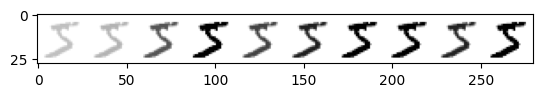

In [ ]:
# Define a single transformation
transform = transforms.ColorJitter(brightness=0.8)

# Generate some output transformations, and show results
def visualize_transforms(image, T, n=10):
  output_transforms = []
  for i in range(n):
    output = T(image)
    output_transforms.append(output[0])

  plt.imshow(np.hstack(output_transforms), cmap=plt.cm.binary)
visualize_transforms(example_image, transform)

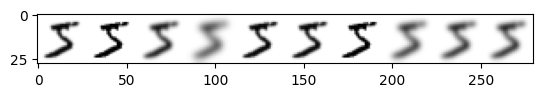

In [ ]:
# Define a single transformation
transform = transforms.GaussianBlur(kernel_size=21)

# Generate some output transformations, and show results
def visualize_transforms(image, T, n=10):
  output_transforms = []
  for i in range(n):
    output = T(image)
    output_transforms.append(output[0])

  plt.imshow(np.hstack(output_transforms), cmap=plt.cm.binary)
visualize_transforms(example_image, transform)

Just like layers in a model, we can layer transformations of our data by composing them together. Let's try combining our previous `ColorJitter` transform with a random rotation transform called `RandomRotation`.

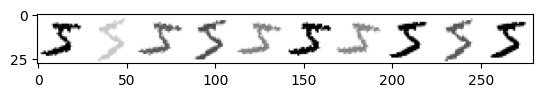

In [ ]:
two_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.8),
    transforms.RandomRotation(degrees=20),
])

visualize_transforms(example_image, two_transforms)

Finally, we can build our final data transform for our MNIST training data. Feel free to add and try out different transforms here to augment your dataset in different ways!

After constructing our transform, we have to add it to our dataset to make sure it gets used during training.

In [ ]:
# Note: to exclude a transform, comment it out with a # before it, ie. #     transforms.RandomRotation(degrees=25),
training_transforms = transforms.Compose([
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomRotation(degrees=25),
    # ... TODO: add any more transforms you would like here! ...
    transforms.ToTensor()
])

# Add our transforms to our training dataset so they are used to augment our
# dataset during training.
training_data.transform = training_transforms

**Question 4:** Data Augmentations

* Why do we augment only the training data and not the testing data?
* The MNIST data is black and white. If the data were color (RGB), what are some other augmentations we could try?


Now that we've augmented our dataset, let's build data loaders to grab and augment our data during training and testing.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Using cuda device


# Part 4: Training and Hyperarameters

In [ ]:
#@title Define training and testing operations

def train(model, optimizer, dataloader, epoch):
  # set model to train mode
  model.train()
  avg_loss = 0
  correct = 0
  for batch_idx, (image, label) in enumerate(tqdm(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # reset optimizer
    optimizer.zero_grad()
    # get output
    output = model(image)
    # compute loss
    loss = nn.CrossEntropyLoss()(output, label)
    # run backpropagation to compute gradient of loss with respect to parameters
    loss.backward()
    # adjust parameters in opposite direction as gradient
    optimizer.step()

    # debugging values
    avg_loss += loss.item() * label.size(0)
    correct += (output.argmax(1) == label).float().sum().item()
    if batch_idx % 100 == 0:
      print(f"Epoch {epoch} training loss: {loss.item():4f}")

  avg_loss /= len(dataloader.dataset)
  correct /= len(dataloader.dataset)
  print(f"\nEpoch {epoch} training accuracy: {100 * correct :4f}%, Epoch {epoch} avg loss: {avg_loss :4f}\n")

def test(model, dataloader, epoch):
  # set model to evaluation mode
  model.eval()
  avg_loss = 0
  correct = 0
  for batch_idx, (image, label) in enumerate(tqdm(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # get output
    output = model(image)
    # compute loss
    loss = nn.CrossEntropyLoss()(output, label)

    # debugging values
    avg_loss += loss.item() * label.size(0)
    correct += (output.argmax(1) == label).float().sum().item()
    if batch_idx % 100 == 0:
      print(f"Epoch {epoch} test loss: {loss.item():4f}")

  avg_loss /= len(dataloader.dataset)
  correct /= len(dataloader.dataset)
  print(f"\nEpoch {epoch} test accuracy: {100 * correct :4f}%, avg loss: {avg_loss :4f}\n")
  return (avg_loss, correct)

Now with our new and improved image CNN model along with our data augmentation pipeline, let's retrain our model from Lab 3 with these new improvements and check out our results!

Try changing the hyperparameters and seeing how the behaviour during training and the graphs of loss and accuracy change. Can you find a sweet spot?

In [ ]:
learning_rate = 1e-4 # 1e-4 # TODO: Try changing the learning rate

num_epochs = 3 # TODO: Try changing the number of epochs

  0%|          | 2/938 [00:00<01:31, 10.25it/s]

Epoch 0 training loss: 2.299489


 11%|█         | 102/938 [00:07<00:58, 14.25it/s]

Epoch 0 training loss: 2.241041


 22%|██▏       | 202/938 [00:15<00:56, 13.07it/s]

Epoch 0 training loss: 1.713949


 32%|███▏      | 304/938 [00:22<00:44, 14.17it/s]

Epoch 0 training loss: 0.979005


 43%|████▎     | 402/938 [00:30<00:38, 14.00it/s]

Epoch 0 training loss: 0.992724


 54%|█████▎    | 502/938 [00:38<00:46,  9.33it/s]

Epoch 0 training loss: 0.724266


 64%|██████▍   | 603/938 [00:46<00:24, 13.94it/s]

Epoch 0 training loss: 0.721071


 75%|███████▍  | 703/938 [00:53<00:16, 14.56it/s]

Epoch 0 training loss: 0.599384


 86%|████████▌ | 803/938 [01:00<00:09, 14.28it/s]

Epoch 0 training loss: 0.555967


 96%|█████████▋| 903/938 [01:08<00:02, 14.13it/s]

Epoch 0 training loss: 0.457875


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]



Epoch 0 training accuracy: 67.690000%, Epoch 0 avg loss: 1.043852



  8%|▊         | 13/157 [00:00<00:01, 120.67it/s]

Epoch 0 test loss: 0.442768


 78%|███████▊  | 123/157 [00:00<00:00, 131.88it/s]

Epoch 0 test loss: 0.258249


100%|██████████| 157/157 [00:01<00:00, 130.87it/s]



Epoch 0 test accuracy: 90.440000%, avg loss: 0.309236



  0%|          | 2/938 [00:00<01:05, 14.33it/s]

Epoch 1 training loss: 0.708582


 11%|█         | 102/938 [00:07<00:58, 14.28it/s]

Epoch 1 training loss: 0.369422


 22%|██▏       | 202/938 [00:15<01:06, 11.02it/s]

Epoch 1 training loss: 0.475950


 32%|███▏      | 304/938 [00:23<00:43, 14.56it/s]

Epoch 1 training loss: 0.358849


 43%|████▎     | 402/938 [00:30<00:37, 14.39it/s]

Epoch 1 training loss: 0.395207


 54%|█████▎    | 502/938 [00:38<00:30, 14.39it/s]

Epoch 1 training loss: 0.410892


 64%|██████▍   | 602/938 [00:45<00:24, 13.68it/s]

Epoch 1 training loss: 0.482182


 75%|███████▍  | 702/938 [00:53<00:21, 10.89it/s]

Epoch 1 training loss: 0.519936


 86%|████████▌ | 802/938 [01:01<00:10, 13.04it/s]

Epoch 1 training loss: 0.398643


 96%|█████████▌| 902/938 [01:09<00:02, 14.13it/s]

Epoch 1 training loss: 0.353871


100%|██████████| 938/938 [01:11<00:00, 13.09it/s]



Epoch 1 training accuracy: 88.845000%, Epoch 1 avg loss: 0.385333



  9%|▉         | 14/157 [00:00<00:01, 137.80it/s]

Epoch 1 test loss: 0.336548


 80%|████████  | 126/157 [00:00<00:00, 129.19it/s]

Epoch 1 test loss: 0.168051


100%|██████████| 157/157 [00:01<00:00, 129.37it/s]



Epoch 1 test accuracy: 93.770000%, avg loss: 0.210164



  0%|          | 2/938 [00:00<01:09, 13.47it/s]

Epoch 2 training loss: 0.282918


 11%|█         | 102/938 [00:07<00:59, 14.08it/s]

Epoch 2 training loss: 0.241025


 22%|██▏       | 202/938 [00:14<00:51, 14.20it/s]

Epoch 2 training loss: 0.219101


 32%|███▏      | 302/938 [00:22<00:49, 12.86it/s]

Epoch 2 training loss: 0.392000


 43%|████▎     | 402/938 [00:30<00:47, 11.22it/s]

Epoch 2 training loss: 0.170723


 54%|█████▎    | 502/938 [00:37<00:30, 14.26it/s]

Epoch 2 training loss: 0.263658


 64%|██████▍   | 602/938 [00:45<00:23, 14.40it/s]

Epoch 2 training loss: 0.323250


 75%|███████▍  | 702/938 [00:52<00:16, 13.98it/s]

Epoch 2 training loss: 0.267891


 86%|████████▌ | 802/938 [00:59<00:09, 14.05it/s]

Epoch 2 training loss: 0.133827


 96%|█████████▌| 902/938 [01:07<00:03, 11.18it/s]

Epoch 2 training loss: 0.330644


100%|██████████| 938/938 [01:09<00:00, 13.41it/s]



Epoch 2 training accuracy: 92.021667%, Epoch 2 avg loss: 0.277247



  9%|▉         | 14/157 [00:00<00:01, 136.33it/s]

Epoch 2 test loss: 0.209035


 80%|████████  | 126/157 [00:00<00:00, 128.54it/s]

Epoch 2 test loss: 0.148632


100%|██████████| 157/157 [00:01<00:00, 132.66it/s]



Epoch 2 test accuracy: 95.150000%, avg loss: 0.157968



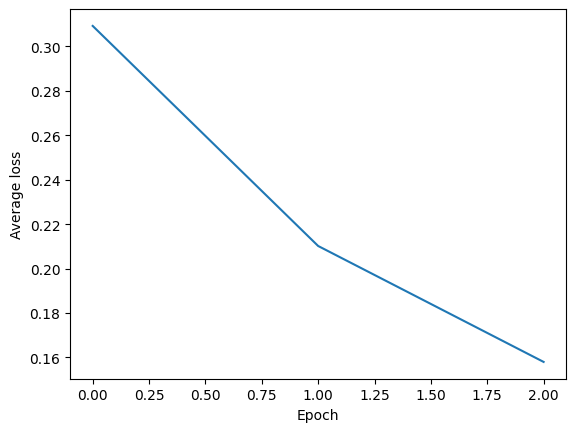

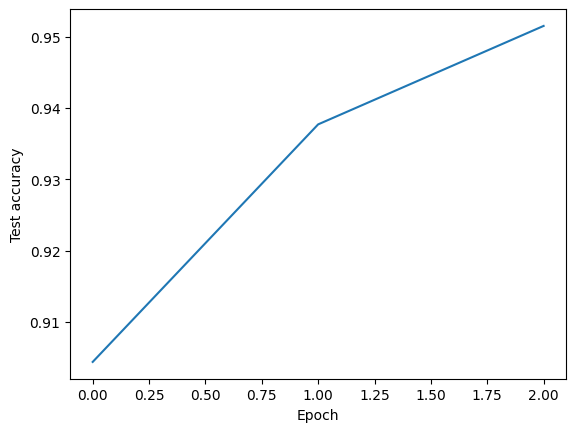

In [ ]:
# Create the optimizer
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

# We use these to store the loss and accuracy to plot them later
losses, accs = [], []

for i in range(num_epochs):
  train(model, optimizer, training_dataloader, i)
  loss, acc = test(model, test_dataloader, i)
  losses.append(loss)
  accs.append(acc)

# Plotting
plt.plot(losses)
plt.ylabel("Average loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(accs)
plt.ylabel("Test accuracy")
plt.xlabel("Epoch")
plt.show()

**Question 5:** CNN Performance & Experiments

* Train a model with just color transform, gausian transform, and rotation transform. Then train a model with all three transforms. Which augmentations help more than others for training and performance? Note: you can use 3 epochs for each experiment and compare the results, it should take around 4 minutes to run each experiment if the GPU is being used.
* Train the CNN without augmentation. How much does performance improve after augmentation?
* Compare the results to the baseline neural network model from the previous lab. How much better is the performance of the CNNs compared to the baseline neural network model?
* Try changing some part of the CNN model, such as the in_channels / out_channels, or the number of layers. How does the performance change?
* Competition time! Try to get the best performance on the test set. You can change anything including learning rate, number of epochs, model size, augmentation, etc...

Congratulations on significantly improving the performance of your image model!! 🎊